In [1]:
from tvb.simulator.models.oscillator import Generic2dOscillator
from tvb.simulator.integrators import HeunStochastic
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import arviz as az
from datetime import datetime
%load_ext autoreload
%autoreload 2

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
a_sim = -2.0
b_sim = -10.0
c_sim = 0.0
d_sim = 0.02
I_sim = 0.0
epsilon = 1.0

In [3]:
# TVB model and integrator setup
oscillator_model = Generic2dOscillator(
    a=np.asarray([a_sim]),
    b=np.asarray([b_sim]),
    c=np.asarray([c_sim]),
    d=np.asarray([d_sim]),
    I=np.asarray([I_sim]),
)
oscillator_model.configure()

integrator = HeunStochastic(dt=0.1)
integrator.noise.configure()
integrator.noise.configure_white(dt=integrator.dt)
integrator.set_random_state(random_state=None)
integrator.configure()
integrator.configure_boundaries(oscillator_model)

In [4]:
simulation_length = 100
stimulus = 0.0
local_coupling = 0.0

current_state_v = np.random.uniform(low=-2.0, high=4.0, size=[1, 1, 1])
current_state_w = np.random.uniform(low=-6.0, high=6.0, size=[1, 1, 1])
current_state = np.vstack([current_state_v, current_state_w])
state = current_state

current_step = 0
number_of_nodes = 1
start_step = current_step + 1
node_coupling = np.zeros([2, 1, 1])
n_steps = int(math.ceil(simulation_length / integrator.dt))

X = [current_state.copy()]
for step in range(start_step, start_step + n_steps):
    state = integrator.integrate(state, oscillator_model, node_coupling, local_coupling, stimulus)
    X.append(state.copy())

X = np.asarray(X)
t = np.linspace(0, simulation_length, n_steps + 1)

In [5]:
X_observed = np.random.normal(X, epsilon)

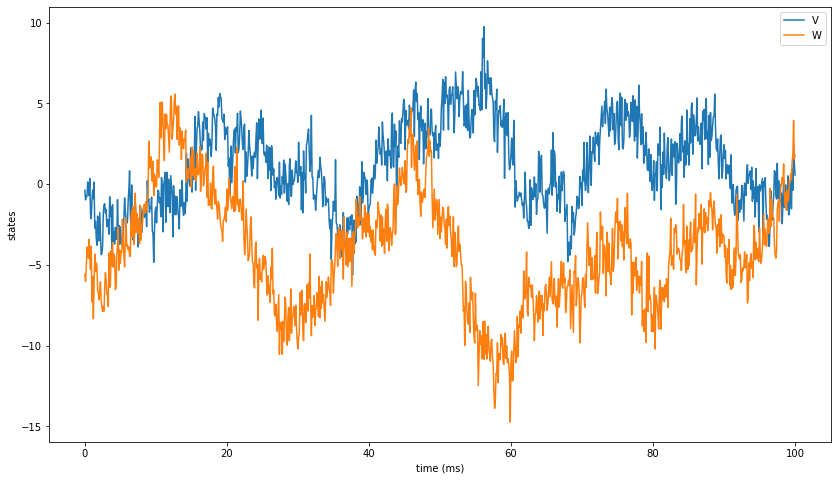

In [7]:
f1 = plt.figure(figsize=(14,8))
plt.plot(t, X_observed[:, 0, 0, 0], label="V")
plt.plot(t, X_observed[:, 1, 0, 0], label="W")
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.legend()
plt.show()

In [21]:
obs = {
    "x_obs": torch.distributions.MultivariateNormal(
        loc=torch.as_tensor(X.reshape(X.size, order="F")),
        scale_tril=torch.diag(torch.as_tensor(epsilon * np.ones(X.size)))
    ).sample()
}

priors = {
    "a": [-2.3, -1.7],
    "b": [-10.5, -9.5],
    "c": [-0.2, 0.2],
    "d": [0.01, 0.03],
    "I": [-0.2, 0.2],
    "epsilon": [0.9, 1.1]
}

shape = X_observed.shape

In [9]:
from tvb.contrib.inversion.sbiInference import sbiModel

/users/erichter/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


### SNPE inference

In [10]:
snpe_model = sbiModel(integrator, oscillator_model, obs, priors, shape)

In [11]:
snpe_model.run_inference(method="SNPE", 
                         num_simulations=800, 
                         num_workers=1, 
                         num_samples=2000)

Running 800 simulations.: 100%|█| 800/8


 Neural network successfully converged after 29 epochs.

Drawing 2000 posterior samples: 2656it [00:01, 2484.88it/s]


In [12]:
inference_data = snpe_model.to_arviz_data()

100%|█| 2000/2000 [02:41<00:00, 12.42it


In [13]:
fn = snpe_model.inference_data.to_netcdf(filename = f"sbi_data/inference_data/{snpe_model.run_id}.nc", 
                                         compress=False)

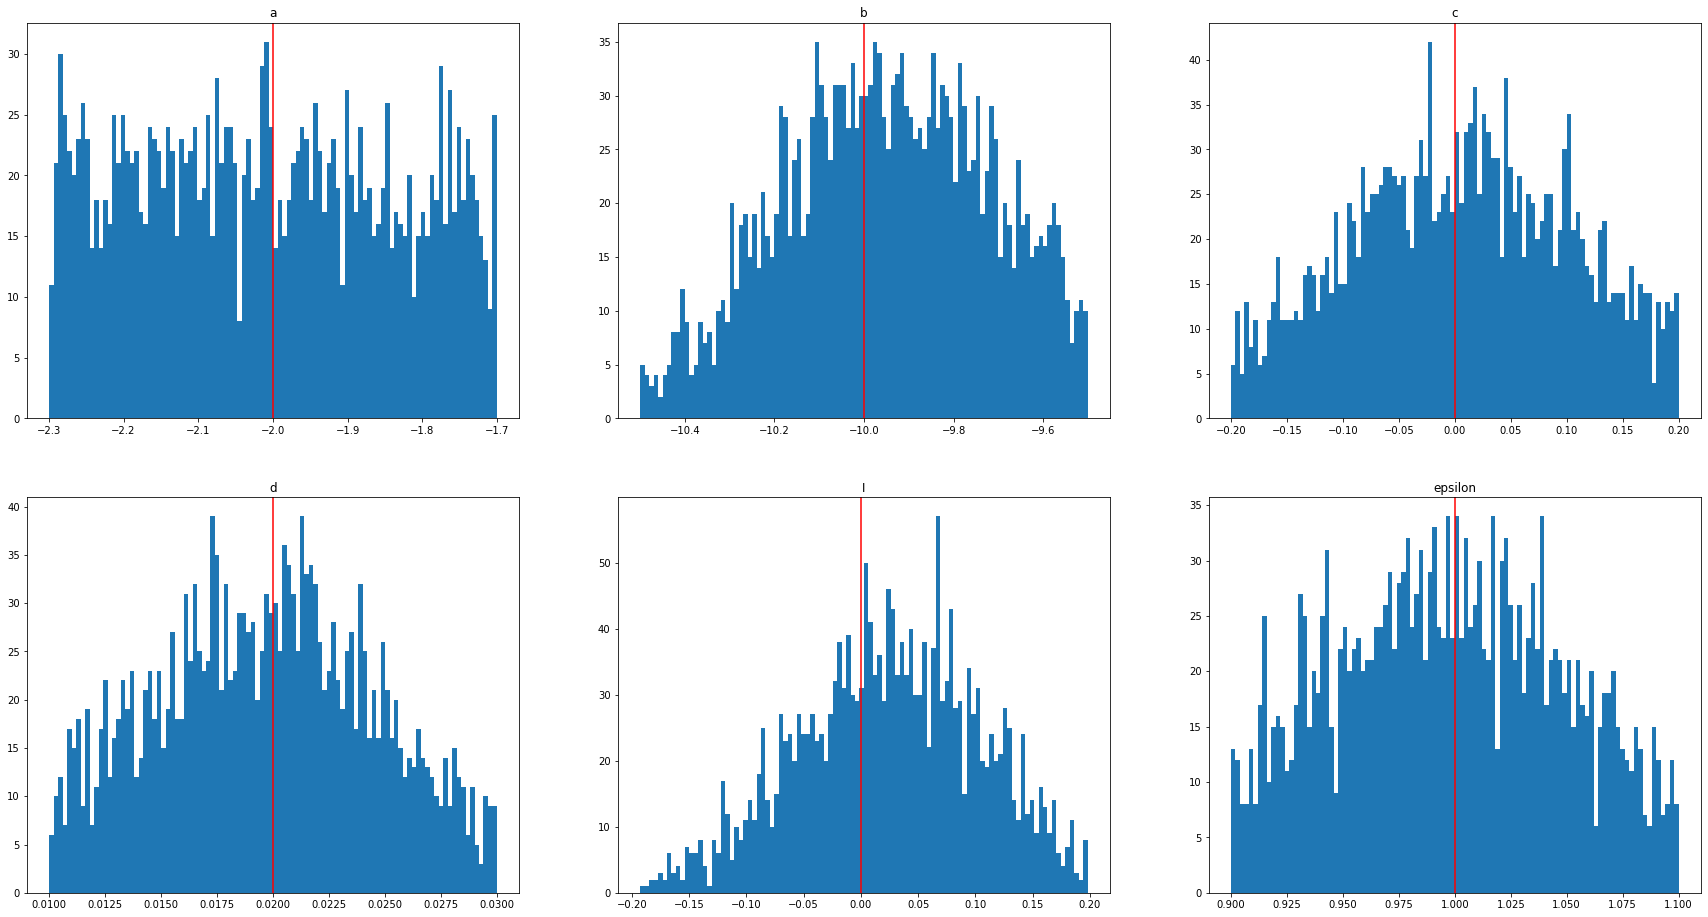

In [14]:
snpe_model.plot_posterior(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": epsilon}
)

In [15]:
map_estimator = snpe_model.get_map_estimator()
map_estimator

Drawing 1000 posterior samples: 1552it [00:00, 2485.09it/s]


tensor([-2.2065, -9.9206,  0.0169,  0.0192,  0.0300,  0.9992])

In [16]:
posterior_sample = snpe_model.get_sample()
posterior_sample

Drawing 1 posterior samples: 2176it [00:00, 2457.05it/s]


tensor([[ -2.1696, -10.3488,   0.0138,   0.0249,  -0.0383,   1.0532]])

In [17]:
posterior_obs = snpe_model.simulation_wrapper(params=map_estimator)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

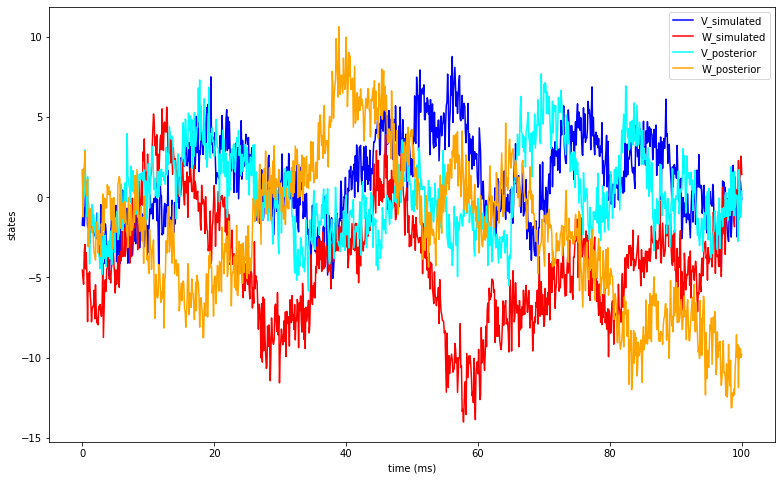

In [19]:
f3 = plt.figure(figsize=(13,8))
#plt.plot(observation["time"], observation["states"])
plt.plot(t, snpe_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(t, snpe_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(t, posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(t, posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [20]:
snpe_model.information_criteria()

/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


{'WAIC': 7063.405389885271, 'LOO': 8111.725136690611}

### SNLE inference

In [22]:
snle_model = sbiModel(integrator, oscillator_model, obs, priors, shape)

In [23]:
snle_model.run_inference(method="SNLE",
                         num_simulations=800,
                         num_workers=1,
                         num_samples=2000)

Running 800 simulations.: 100%|█| 800/8


 Neural network successfully converged after 225 epochs.

Sample: 100%|█| 20011/20011 [45:57,  7.26it/s, step size=1.65e-01, acc. prob=0.8


In [24]:
inference_data = snle_model.to_arviz_data()

100%|█| 2000/2000 [03:28<00:00,  9.59it


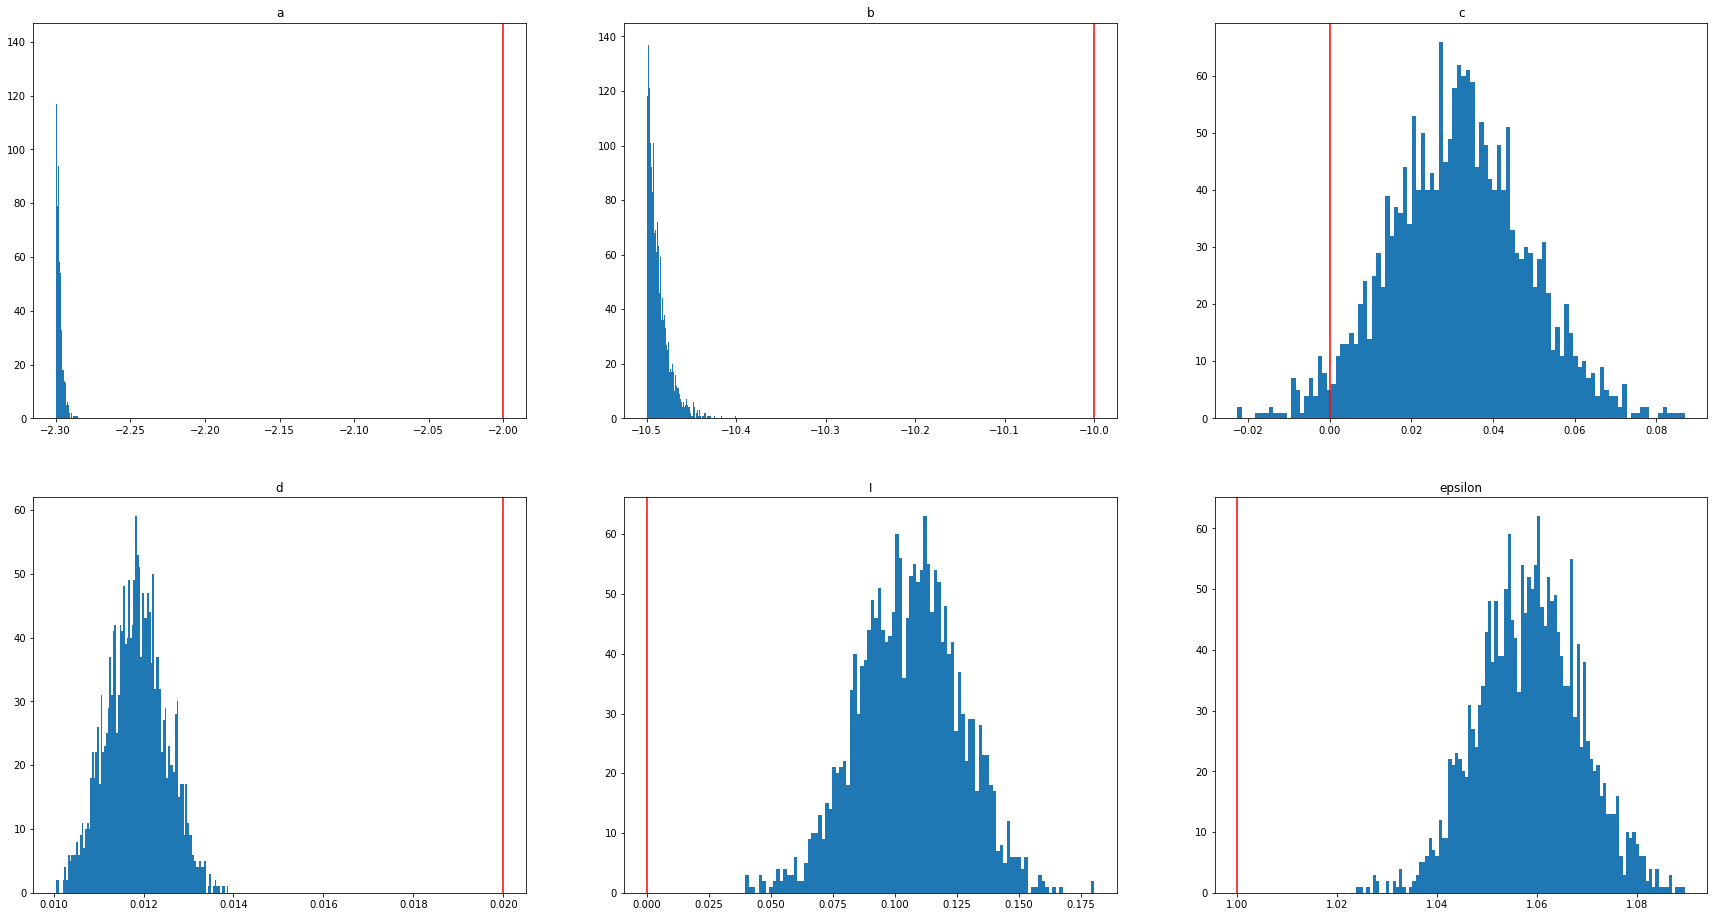

In [25]:
snle_model.plot_posterior(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": epsilon}
)

In [26]:
map_estimator = snle_model.get_map_estimator()
map_estimator

tensor([ -2.2994, -10.4999,   0.0299,   0.0118,   0.1058,   1.0601])

In [27]:
posterior_sample = snle_model.get_sample()
posterior_sample

Sample: 100%|████| 21/21 [00:02,  9.10it/s, step size=1.51e-01, acc. prob=0.923]


tensor([[ -2.2939, -10.4979,   0.0450,   0.0129,   0.1304,   1.0623]])

In [30]:
posterior_obs = snle_model.simulation_wrapper(params=map_estimator)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

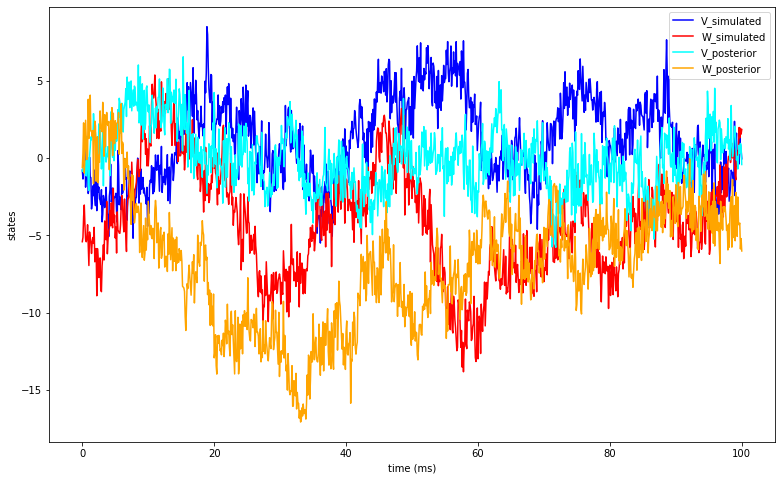

In [31]:
f4 = plt.figure(figsize=(13,8))
plt.plot(t, snle_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(t, snle_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(t, posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(t, posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [44]:
snle_model.information_criteria()

/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


{'WAIC': 7297.424146523084, 'LOO': 8340.628028174739}

### SNRE inference

In [38]:
snre_model = sbiModel(integrator, oscillator_model, obs, priors, shape)

In [40]:
snre_model.run_inference(method="SNRE",
                         num_simulations=800,
                         num_workers=1,
                         num_samples=2000)


Running 800 simulations.:   0%| | 0/800
Running 800 simulations.:   0%| | 1/800
Running 800 simulations.:   0%| | 3/800
Running 800 simulations.:   1%| | 5/800
Running 800 simulations.:   1%| | 7/800
Running 800 simulations.:   1%| | 9/800
Running 800 simulations.:   1%| | 11/80
Running 800 simulations.:   2%| | 13/80
Running 800 simulations.:   2%| | 15/80
Running 800 simulations.:   2%| | 17/80
Running 800 simulations.:   2%| | 19/80
Running 800 simulations.:   3%| | 21/80
Running 800 simulations.:   3%| | 23/80
Running 800 simulations.:   3%| | 25/80
Running 800 simulations.:   3%| | 27/80
Running 800 simulations.:   4%| | 29/80
Running 800 simulations.:   4%| | 31/80
Running 800 simulations.:   4%| | 33/80
Running 800 simulations.:   4%| | 35/80
Running 800 simulations.:   5%| | 37/80
Running 800 simulations.:   5%| | 39/80
Running 800 simulations.:   5%| | 41/80
Running 800 simulations.:   5%| | 43/80
Running 800 simulations.:   6%| | 45/80
Running 800 simulations.:   6%| | 47/80

Running 800 simulations.:  47%|▍| 379/8
Running 800 simulations.:  48%|▍| 381/8
Running 800 simulations.:  48%|▍| 383/8
Running 800 simulations.:  48%|▍| 385/8
Running 800 simulations.:  48%|▍| 387/8
Running 800 simulations.:  49%|▍| 389/8
Running 800 simulations.:  49%|▍| 391/8
Running 800 simulations.:  49%|▍| 393/8
Running 800 simulations.:  49%|▍| 395/8
Running 800 simulations.:  50%|▍| 397/8
Running 800 simulations.:  50%|▍| 399/8
Running 800 simulations.:  50%|▌| 401/8
Running 800 simulations.:  50%|▌| 403/8
Running 800 simulations.:  51%|▌| 405/8
Running 800 simulations.:  51%|▌| 407/8
Running 800 simulations.:  51%|▌| 409/8
Running 800 simulations.:  51%|▌| 411/8
Running 800 simulations.:  52%|▌| 413/8
Running 800 simulations.:  52%|▌| 415/8
Running 800 simulations.:  52%|▌| 417/8
Running 800 simulations.:  52%|▌| 419/8
Running 800 simulations.:  53%|▌| 421/8
Running 800 simulations.:  53%|▌| 423/8
Running 800 simulations.:  53%|▌| 425/8
Running 800 simulations.:  53%|▌| 427/8


Running 800 simulations.:  95%|▉| 759/8
Running 800 simulations.:  95%|▉| 761/8
Running 800 simulations.:  95%|▉| 763/8
Running 800 simulations.:  96%|▉| 765/8
Running 800 simulations.:  96%|▉| 767/8
Running 800 simulations.:  96%|▉| 769/8
Running 800 simulations.:  96%|▉| 771/8
Running 800 simulations.:  97%|▉| 773/8
Running 800 simulations.:  97%|▉| 775/8
Running 800 simulations.:  97%|▉| 777/8
Running 800 simulations.:  97%|▉| 779/8
Running 800 simulations.:  98%|▉| 781/8
Running 800 simulations.:  98%|▉| 783/8
Running 800 simulations.:  98%|▉| 785/8
Running 800 simulations.:  98%|▉| 787/8
Running 800 simulations.:  99%|▉| 789/8
Running 800 simulations.:  99%|▉| 791/8
Running 800 simulations.:  99%|▉| 793/8
Running 800 simulations.:  99%|▉| 795/8
Running 800 simulations.: 100%|▉| 797/8
Running 800 simulations.: 100%|█| 800/8

2022-07-05 23:22:34,165 - WARNING - root - num_atoms=10 was clamped to 2; must be in [2,1] range


 Neural network successfully converged after 62 epochs.

Sample: 100%|█| 20011/20011 [04:46, 69.74it/s, step size=8.72e-01, acc. prob=0.9


In [50]:
inference_data = snre_model.to_arviz_data()


  4%|██▎                                                         | 78/2000 [00:08<03:15,  9.83it/s]


  8%|████▋                                                      | 157/2000 [00:16<03:09,  9.73it/s]


 12%|██████▉                                                    | 236/2000 [00:24<03:34,  8.23it/s]


 16%|█████████▎                                                 | 315/2000 [00:33<02:59,  9.39it/s]


 20%|███████████▌                                               | 394/2000 [00:41<02:45,  9.70it/s]


 24%|█████████████▉                                             | 473/2000 [00:49<02:49,  8.98it/s]


 28%|████████████████▎                                          | 552/2000 [00:57<02:30,  9.65it/s]


 32%|██████████████████▌                                        | 631/2000 [01:06<02:20,  9.72it/s]


 36%|████████████████████▉                                      | 710/2000 [01:14<02:19,  9.27it/s]


 39%|███████████████████████▎                                   | 789/2000 [01:22<02:03,  9.81it/s]


 43%|█████████████████████████▌                                 | 868/2000 [01:31<01:57,  9.62it/s]


 47%|███████████████████████████▉                               | 947/2000 [01:39<01:47,  9.78it/s]


 51%|█████████████████████████████▊                            | 1026/2000 [01:47<01:40,  9.69it/s]


 55%|████████████████████████████████                          | 1105/2000 [01:55<01:36,  9.27it/s]


 59%|██████████████████████████████████▎                       | 1184/2000 [02:03<01:23,  9.74it/s]


 63%|████████████████████████████████████▋                     | 1263/2000 [02:12<01:18,  9.41it/s]


 67%|██████████████████████████████████████▉                   | 1342/2000 [02:20<01:08,  9.65it/s]


 71%|█████████████████████████████████████████▏                | 1421/2000 [02:28<00:59,  9.70it/s]


 75%|███████████████████████████████████████████▌              | 1500/2000 [02:37<00:59,  8.36it/s]


 79%|█████████████████████████████████████████████▊            | 1579/2000 [02:45<00:43,  9.77it/s]


 83%|████████████████████████████████████████████████          | 1658/2000 [02:54<00:35,  9.66it/s]


 87%|██████████████████████████████████████████████████▎       | 1737/2000 [03:02<00:27,  9.71it/s]


 91%|████████████████████████████████████████████████████▋     | 1816/2000 [03:10<00:19,  9.36it/s]


 95%|██████████████████████████████████████████████████████▉   | 1895/2000 [03:19<00:11,  8.78it/s]


 99%|█████████████████████████████████████████████████████████▏| 1974/2000 [03:27<00:02,  9.62it/s]


100%|██████████████████████████████████████████████████████████| 2000/2000 [03:30<00:00,  9.49it/s]


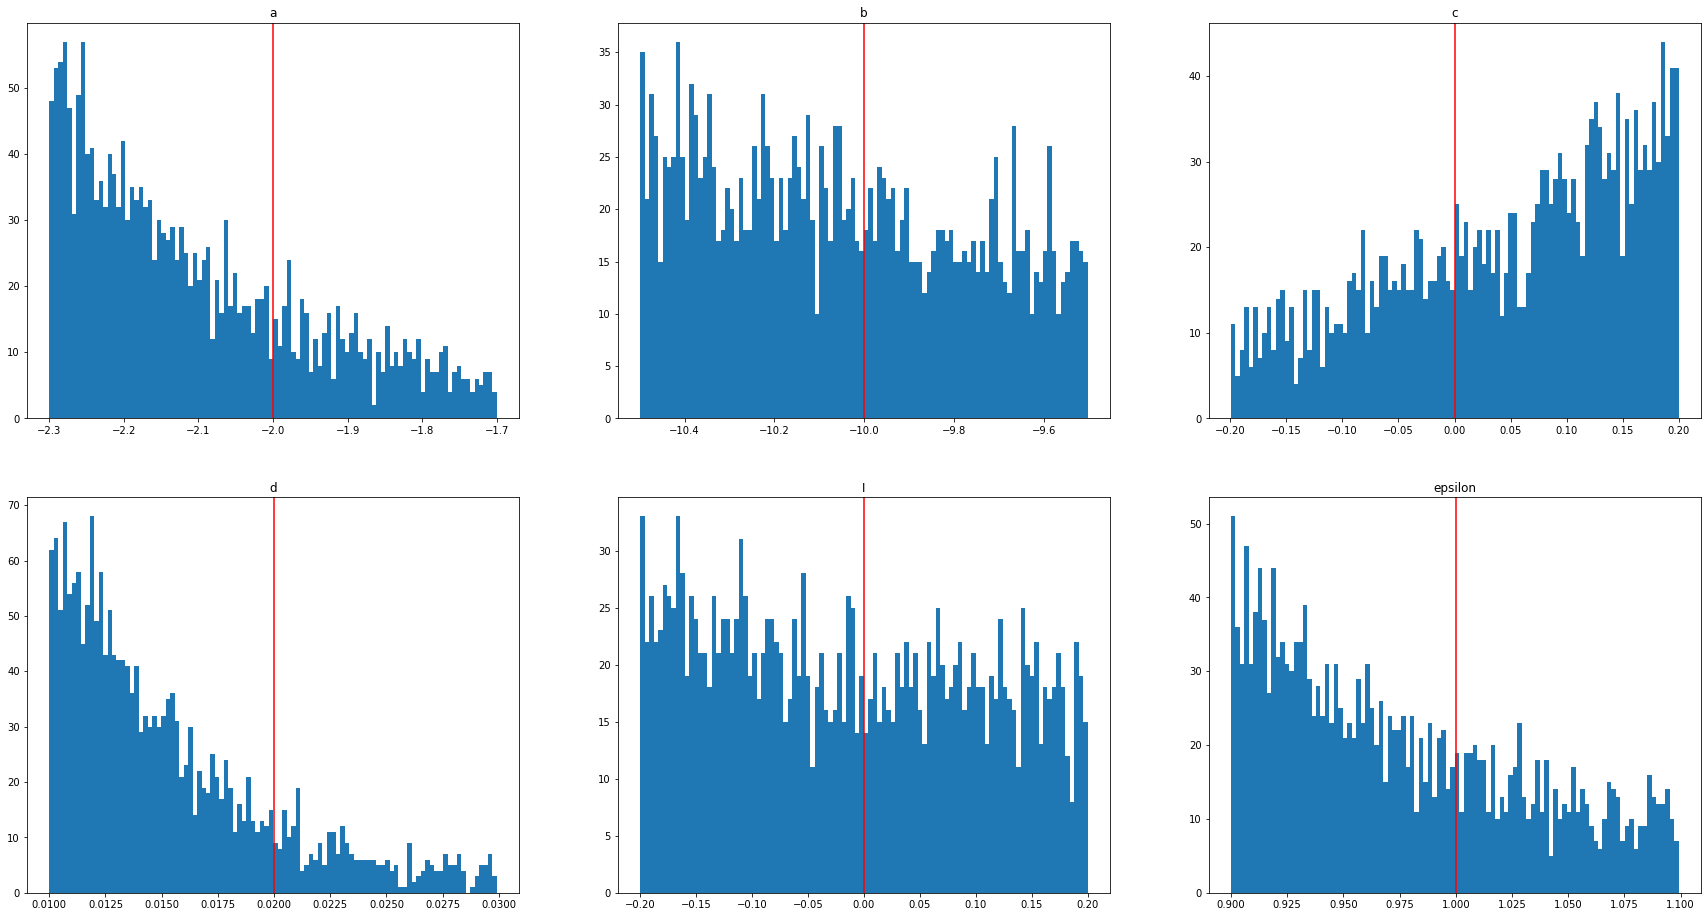

In [42]:
snre_model.plot_posterior(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": epsilon}
)

In [43]:
map_estimator = snre_model.get_map_estimator()
map_estimator

tensor([-2.2999e+00, -1.0481e+01,  1.9937e-01,  1.0033e-02, -1.9414e-01,
         9.0034e-01])

In [45]:
posterior_sample = snre_model.get_sample()
posterior_sample

Sample: 100%|████| 21/21 [00:00, 61.12it/s, step size=1.28e+00, acc. prob=0.886]


tensor([[-2.2987, -9.8003,  0.1797,  0.0149, -0.1378,  0.9144]])

In [46]:
posterior_obs = snre_model.simulation_wrapper(params=map_estimator)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

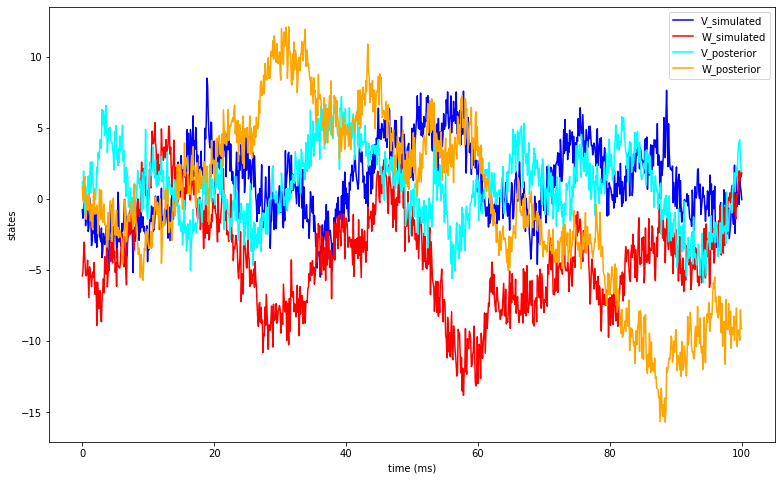

In [47]:
f4 = plt.figure(figsize=(13,8))
plt.plot(t, snre_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(t, snre_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(t, posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(t, posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [48]:
snre_model.information_criteria()

/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


{'WAIC': 6966.283338231567, 'LOO': 7993.400372639958}